In [1]:
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from plotly.offline import iplot
import plotly.figure_factory as ff

# Read the Clean Data

In [2]:
working_directory = os.getcwd()
print(working_directory)
data = pd.read_csv(f"{working_directory}/Input_Data/creditcard_cleaned.csv") #Change the path to your dataset, if needed

c:\Users\teovr\Desktop\Projects\Predicting_Fraudulent_Transactions_With_Machine_Learning


# Data Exploration

## Transaction Distribution by Fraud Flag

In [3]:
# Create a bar chart to show the distribution of the Fraud_Flag variable
count = data["Fraud_Flag"].value_counts()
bar_plot = pd.DataFrame({'Fraud_Flag': count.index, 'values': count.values})

# Set colors for the bars (red for fraud, green for not fraud)
colors = ['green' if flag == 0 else 'red' for flag in bar_plot['Fraud_Flag']]

# Create the bar chart
trace = go.Bar(
    x=['Not Fraud', 'Fraud'],  
    y=bar_plot['values'],
    name="Fraud Flag Distribution",
    marker=dict(color=colors),
    text=bar_plot['values'],  
    textposition='auto'  
)

# Define the layout
layout = go.Layout(
    title=dict(
        text='Fraud Flag Distribution (Not Fraud = 0, Fraud = 1)',
        font=dict(size=18, family='Arial, sans-serif', color='black'),
        x=0.5,  
        xanchor='center'
    ),
    xaxis=dict(
        title=dict(
            text='Fraud Flag',
            font=dict(size=14)  
        ),
        tickvals=[0, 1],  # Only show ticks for 0 and 1
        ticktext=['Not Fraud', 'Fraud'],  
        tickfont=dict(size=12)  
    ),
    yaxis=dict(
        title=dict(
            text='Number of Transactions',
            font=dict(size=14)  
        ),
        tickfont=dict(size=12)  
    ),
    hovermode='closest',
    width=800,  
    height=500,  
    margin=dict(l=50, r=50, t=80, b=50),  
    bargap=0.3  
)

# Combine the data and layout into a figure
fig = go.Figure(data=[trace], layout=layout)

# Display the plot
iplot(fig)

# Print the number of fraudulent transactions
print("Fraudulent transactions in the dataset:", bar_plot['values'][1], "(", round(bar_plot['values'][1] / data.shape[0] * 100, 2), "%)")

Fraudulent transactions in the dataset: 492 ( 0.17 %)


## Transactions Time Density Plot

In [4]:
# Create a new variable for the density plot data
data_for_density_plot = data.copy()
data_for_density_plot['Transaction_Hour_24'] = (data_for_density_plot['Transaction_Time'] % (24 * 3600)) / 3600  # Convert seconds to hours (0-24)

# Separate the transaction times for fraud and non-fraud cases
nfraud = data_for_density_plot.loc[data_for_density_plot['Fraud_Flag'] == 0]["Transaction_Hour_24"]
fraud = data_for_density_plot.loc[data_for_density_plot['Fraud_Flag'] == 1]["Transaction_Hour_24"]

# Prepare data for the density plot
hist_data = [nfraud, fraud]
group_labels = ['Not Fraud', 'Fraud']

# Specify colors for the groups (green for not fraud, red for fraud)
colors = ['green', 'red']

# Create the density plot
fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False, colors=colors)

# Set the layout for the density plot
fig.update_layout(
    title=dict(
        text='Transactions Time Density Plot (24-Hour Period)',
        font=dict(size=18, family='Arial, sans-serif', color='black'),
        x=0.5,  # Center the title
        xanchor='center'
    ),
    xaxis=dict(
        title=dict(
            text='Time of Day',
            font=dict(size=14)
        ),
        tickvals=list(range(0, 25, 2)),  # Add ticks every 2 hours
        ticktext=[f'{hour}:00' for hour in range(0, 25, 2)],  # Format ticks as "hour:00"
        gridcolor='lightgray',
        zeroline=False
    ),
    yaxis=dict(
        title=dict(
            text='Density',
            font=dict(size=14)
        ),
        gridcolor='lightgray'
    ),
    legend=dict(
        title=dict(
            text='Fraud Flag',
            font=dict(size=12)
        ),
        font=dict(size=12),
        traceorder="normal",
        bgcolor='rgba(255,255,255,0.5)',  
        bordercolor='black',
        borderwidth=1
    ),
    width=1000,
    height=500,
    margin=dict(l=50, r=50, t=80, b=50)  
)

# Display the plot
iplot(fig, filename='dist_24_hour')

##### The fraudulent transactions are more evenly distributed over time compared to the non-fraudulent transactions.  
##### The fraudsters may be more active at the beginning of the transaction period, possibly to exploit vulnerabilities before they are detected.
##### We can also see that during the night hours, the number of non-fraudulent transactions is very low, which is expected as fewer people are likely to be making transactions during the night (Europe timezones).

## Analyzing Transaction Time Patterns

In [5]:
# Convert Transaction_Time from seconds to hours (0-24)
data['Hour'] = data['Transaction_Time'].apply(lambda x: np.floor(x / 3600))

# Group the data by 'Hour' and 'Fraud_Flag', and calculate statistics for 'Transaction_Amount'
data_grouped = data.groupby(['Hour', 'Fraud_Flag'])['Transaction_Amount'].aggregate(
    ['min', 'max', 'count', 'sum', 'mean', 'median', 'var']
).reset_index()

# Convert the grouped data into a DataFrame
data_grouped_df = pd.DataFrame(data_grouped)

# Rename columns for better readability
data_grouped_df.columns = [
    'Hour',          # Hour of the day (0-24)
    'Fraud_Flag',    # Fraud flag (0 = Not Fraud, 1 = Fraud)
    'Min',           # Minimum transaction amount
    'Max',           # Maximum transaction amount
    'Transactions',  # Number of transactions
    'Sum',           # Total transaction amount
    'Mean',          # Average transaction amount
    'Median',        # Median transaction amount
    'Variance'       # Variance of transaction amounts
]

# Display the first 20 rows of the grouped DataFrame
print("Grouped Data (First 20 Rows):")
display(data_grouped_df.head(20))

Grouped Data (First 20 Rows):


,Hour,Fraud_Flag,Min,Max,Transactions,Sum,Mean,Median,Variance
0,0.0,0,0.00,7712.43,3961,256572.87,64.774772,12.990,45615.821201
1,0.0,1,0.00,529.00,2,529.00,264.500000,264.500,139920.500000
2,1.0,0,0.00,1769.69,2215,145806.76,65.826980,22.820,20053.615770
3,1.0,1,59.00,239.93,2,298.93,149.465000,149.465,16367.832450
4,2.0,0,0.00,4002.88,1555,106989.39,68.803466,17.900,45355.430437
5,2.0,1,1.00,1809.68,21,1829.78,87.132381,1.000,155776.441219
6,3.0,0,0.00,1903.26,1808,94086.79,52.039154,15.950,16741.786661
7,3.0,1,0.00,179.66,13,220.05,16.926923,1.000,2457.208190
8,4.0,0,0.00,2126.13,1076,79050.36,73.466877,15.950,24416.863654
9,4.0,1,1.00,766.36,6,790.26,131.710000,3.860,96679.482040


## Total Transaction Amount by Hour 

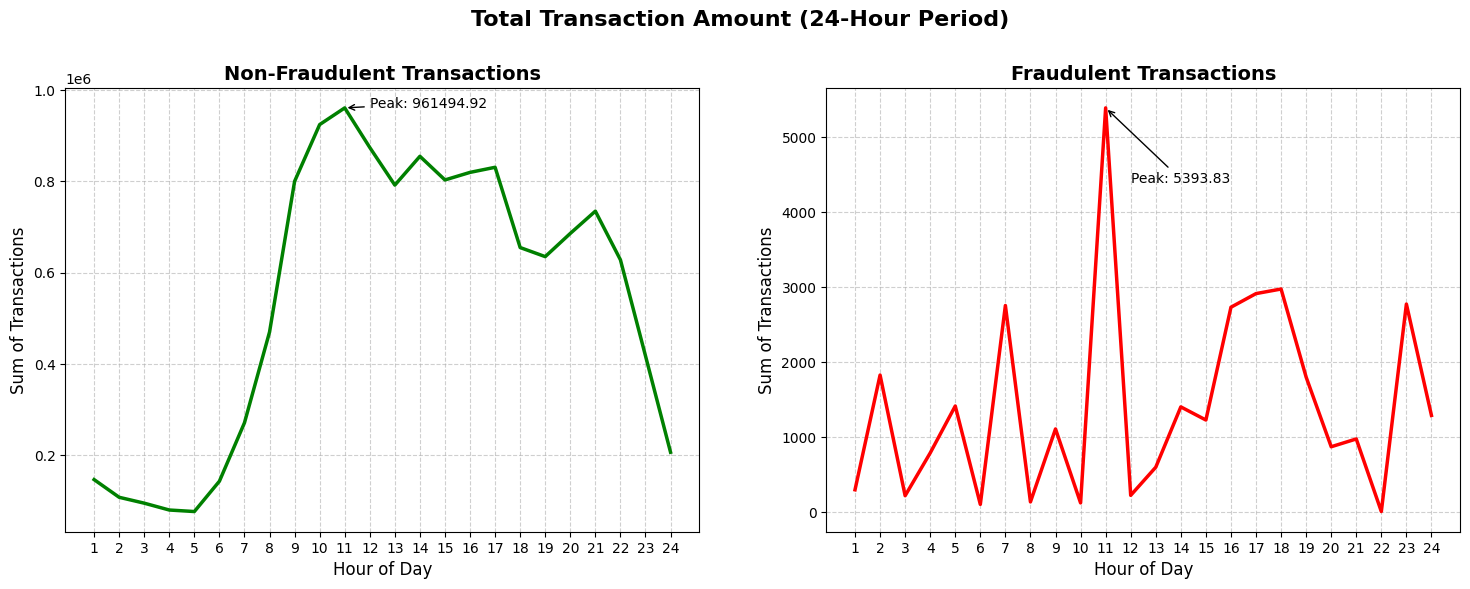

In [6]:
# Filter the data to include only a 24-hour period
data_grouped_df_24h = data_grouped_df[data_grouped_df['Hour'].between(1, 24)]

# Create a line chart
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 6), dpi=100, gridspec_kw={'wspace': 0.2})

# Plot for non-fraudulent transactions
sns.lineplot(
    ax=ax1, 
    x="Hour", 
    y="Sum", 
    data=data_grouped_df_24h.loc[data_grouped_df_24h.Fraud_Flag == 0], 
    color="green", 
    linewidth=2.5, 
)
ax1.set_title("Non-Fraudulent Transactions", fontsize=14, fontweight="bold")
ax1.set_xlabel("Hour of Day", fontsize=12)
ax1.set_ylabel("Sum of Transactions", fontsize=12)
ax1.set_xticks(range(1, 25))
ax1.grid(visible=True, linestyle="--", alpha=0.6)

# Peak for non-fraudulent transactions
peak_hour_nf = data_grouped_df_24h.loc[data_grouped_df_24h.Fraud_Flag == 0].sort_values(by="Sum", ascending=False).iloc[0]
ax1.annotate(
    f"Peak: {peak_hour_nf['Sum']:.2f}",
    xy=(peak_hour_nf['Hour'], peak_hour_nf['Sum']),
    xytext=(peak_hour_nf['Hour'] + 1, peak_hour_nf['Sum'] + 1000),
    arrowprops=dict(facecolor='black', arrowstyle="->"),
    fontsize=10
)

# Plot for fraudulent transactions
sns.lineplot(
    ax=ax2, 
    x="Hour", 
    y="Sum", 
    data=data_grouped_df_24h.loc[data_grouped_df_24h.Fraud_Flag == 1], 
    color="red", 
    linewidth=2.5, 
)
ax2.set_title("Fraudulent Transactions", fontsize=14, fontweight="bold")
ax2.set_xlabel("Hour of Day", fontsize=12)
ax2.set_ylabel("Sum of Transactions", fontsize=12)
ax2.set_xticks(range(1, 25))
ax2.grid(visible=True, linestyle="--", alpha=0.6)

# Peak for fraudulent transactions
peak_hour_f = data_grouped_df_24h.loc[data_grouped_df_24h.Fraud_Flag == 1].sort_values(by="Sum", ascending=False).iloc[0]
y_offset = 1000 if peak_hour_f['Sum'] < ax2.get_ylim()[1] - 1000 else -1000
ax2.annotate(
    f"Peak: {peak_hour_f['Sum']:.2f}",
    xy=(peak_hour_f['Hour'], peak_hour_f['Sum']),
    xytext=(peak_hour_f['Hour'] + 1, peak_hour_f['Sum'] + y_offset),
    arrowprops=dict(facecolor='black', arrowstyle="->"),
    fontsize=10
)

# Set the title
plt.suptitle("Total Transaction Amount (24-Hour Period)", fontsize=16, fontweight="bold")

# Adjust the layout so that the title doesn't overlap with the plots
plt.subplots_adjust(top=0.85)  
#plt.tight_layout(rect=[0, 0, 1, 0.95]) - uncomment if needed for better spacing

# Display the plot
plt.show()

## Number of Transaction by Hour

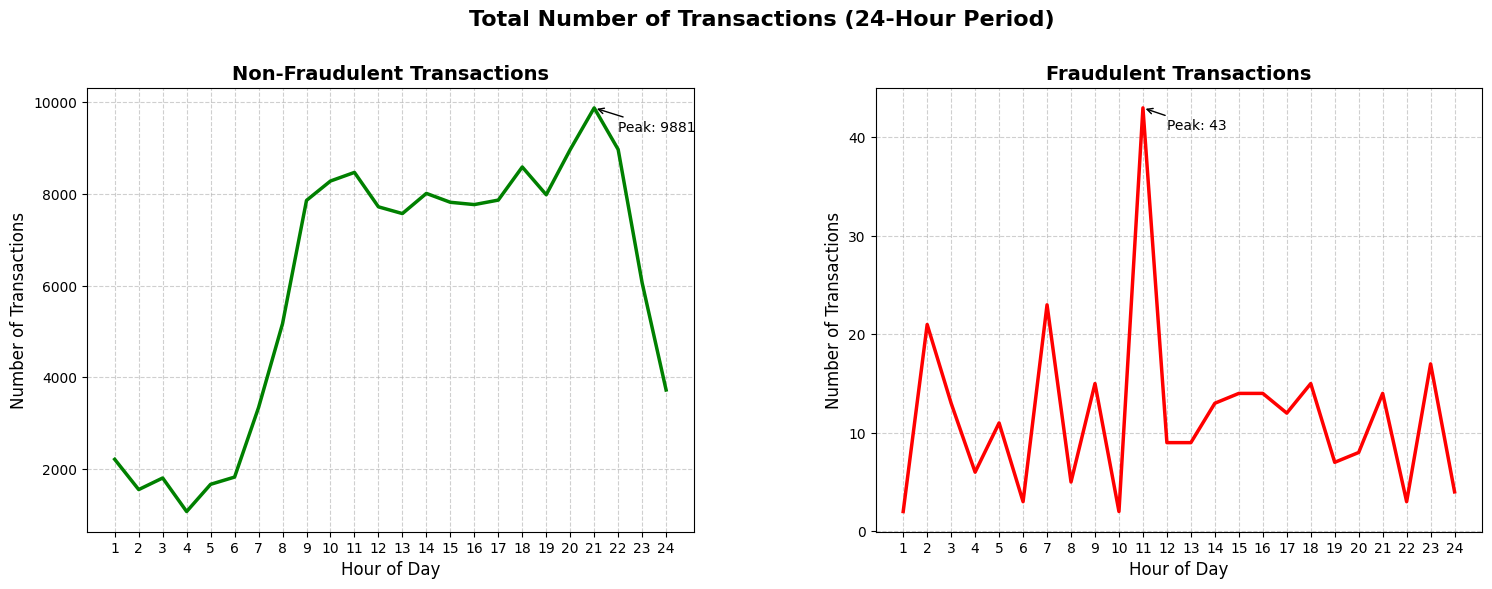

In [7]:
# Create a line chart
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 6), dpi=100, gridspec_kw={'wspace': 0.3})

# Plot for non-fraudulent transactions
sns.lineplot(
    ax=ax1, 
    x="Hour", 
    y="Transactions", 
    data=data_grouped_df_24h.loc[data_grouped_df_24h.Fraud_Flag == 0], 
    color="green", 
    linewidth=2.5, 
)
ax1.set_title("Non-Fraudulent Transactions", fontsize=14, fontweight="bold")
ax1.set_xlabel("Hour of Day", fontsize=12)
ax1.set_ylabel("Number of Transactions", fontsize=12)
ax1.set_xticks(range(1, 25))
ax1.grid(visible=True, linestyle="--", alpha=0.6)

# Peak for non-fraudulent transactions
peak_hour_nf = data_grouped_df_24h.loc[data_grouped_df_24h.Fraud_Flag == 0].sort_values(by="Transactions", ascending=False).iloc[0]
ax1.annotate(
    f"Peak: {int(peak_hour_nf['Transactions'])}",  # Convert to integer
    xy=(peak_hour_nf['Hour'], peak_hour_nf['Transactions']),
    xytext=(peak_hour_nf['Hour'] + 1, peak_hour_nf['Transactions'] - ax1.get_ylim()[1] * 0.05),  
    arrowprops=dict(facecolor='black', arrowstyle="->"),
    fontsize=10
)

# Plot for fraudulent transactions
sns.lineplot(
    ax=ax2, 
    x="Hour", 
    y="Transactions", 
    data=data_grouped_df_24h.loc[data_grouped_df_24h.Fraud_Flag == 1], 
    color="red", 
    linewidth=2.5, 
)
ax2.set_title("Fraudulent Transactions", fontsize=14, fontweight="bold")
ax2.set_xlabel("Hour of Day", fontsize=12)
ax2.set_ylabel("Number of Transactions", fontsize=12)
ax2.set_xticks(range(1, 25))
ax2.grid(visible=True, linestyle="--", alpha=0.6)

# Peak for fraudulent transactions
peak_hour_f = data_grouped_df_24h.loc[data_grouped_df_24h.Fraud_Flag == 1].sort_values(by="Transactions", ascending=False).iloc[0]
ax2.annotate(
    f"Peak: {int(peak_hour_f['Transactions'])}",  # Convert to integer
    xy=(peak_hour_f['Hour'], peak_hour_f['Transactions']),
    xytext=(peak_hour_f['Hour'] + 1, peak_hour_f['Transactions'] - ax2.get_ylim()[1] * 0.05),  
    arrowprops=dict(facecolor='black', arrowstyle="->"),
    fontsize=10
)

# Set the title
plt.suptitle("Total Number of Transactions (24-Hour Period)", fontsize=16, fontweight="bold")

# Adjust the layout so that the title doesn't overlap with the plots
plt.subplots_adjust(top=0.85)  
#plt.tight_layout(rect=[0, 0, 1, 0.95]) - uncomment if needed for better spacing

# Display the plot
plt.show()

## Average Amount of Transaction by Hour

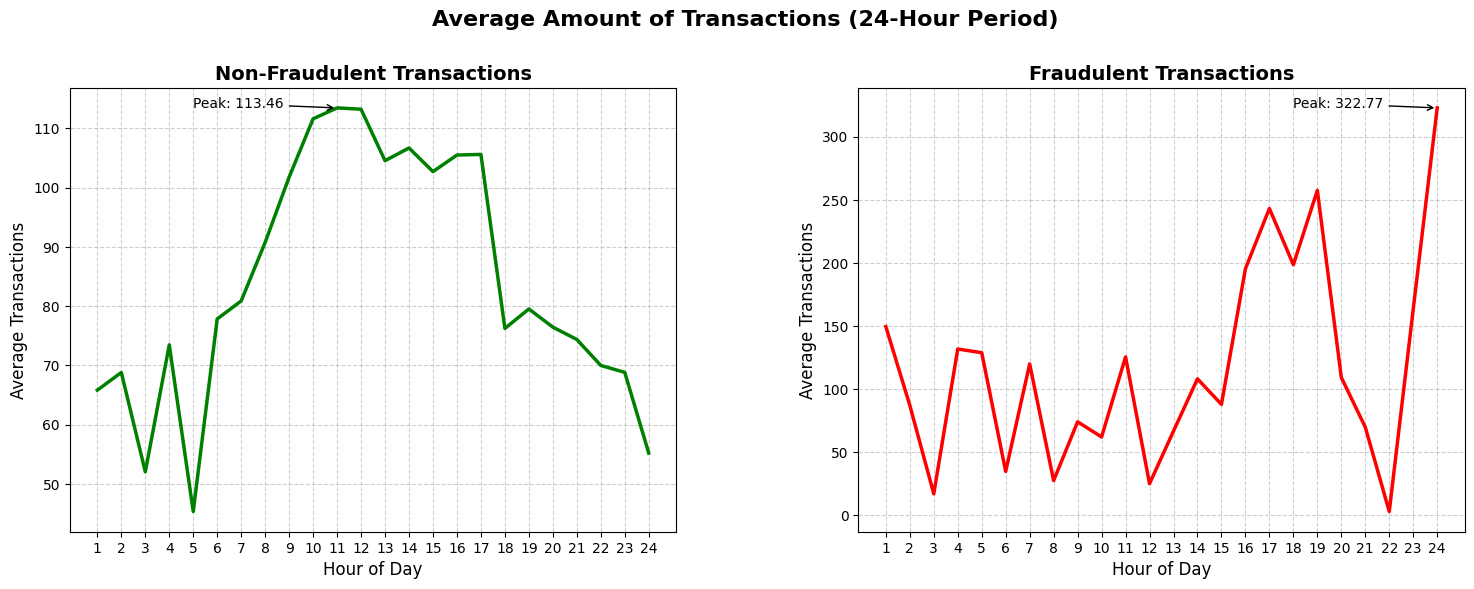

In [8]:
# Create a line chart
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 6), dpi=100, gridspec_kw={'wspace': 0.3})

# Plot for non-fraudulent transactions
sns.lineplot(
    ax=ax1, 
    x="Hour", 
    y="Mean", 
    data=data_grouped_df_24h.loc[data_grouped_df_24h.Fraud_Flag == 0], 
    color="green", 
    linewidth=2.5, 
)
ax1.set_title("Non-Fraudulent Transactions", fontsize=14, fontweight="bold")
ax1.set_xlabel("Hour of Day", fontsize=12)
ax1.set_ylabel("Average Transactions", fontsize=12)
ax1.set_xticks(range(1, 25))
ax1.grid(visible=True, linestyle="--", alpha=0.6)

# Peak for non-fraudulent transactions
peak_hour_nf = data_grouped_df_24h.loc[data_grouped_df_24h.Fraud_Flag == 0].sort_values(by="Mean", ascending=False).iloc[0]
ax1.annotate(
    f"Peak: {peak_hour_nf['Mean']:.2f}",
    xy=(peak_hour_nf['Hour'], peak_hour_nf['Mean']),
    xytext=(peak_hour_nf['Hour'] - 6, peak_hour_nf['Mean']),  
    arrowprops=dict(facecolor='black', arrowstyle="->"),
    fontsize=10
)

# Plot for fraudulent transactions
sns.lineplot(
    ax=ax2, 
    x="Hour", 
    y="Mean", 
    data=data_grouped_df_24h.loc[data_grouped_df_24h.Fraud_Flag == 1], 
    color="red", 
    linewidth=2.5, 
)
ax2.set_title("Fraudulent Transactions", fontsize=14, fontweight="bold")
ax2.set_xlabel("Hour of Day", fontsize=12)
ax2.set_ylabel("Average Transactions", fontsize=12)
ax2.set_xticks(range(1, 25))
ax2.grid(visible=True, linestyle="--", alpha=0.6)

# Peak for fraudulent transactions
peak_hour_f = data_grouped_df_24h.loc[data_grouped_df_24h.Fraud_Flag == 1].sort_values(by="Mean", ascending=False).iloc[0]
ax2.annotate(
    f"Peak: {peak_hour_f['Mean']:.2f}",
    xy=(peak_hour_f['Hour'], peak_hour_f['Mean']),
    xytext=(peak_hour_f['Hour'] - 6, peak_hour_f['Mean']),  
    arrowprops=dict(facecolor='black', arrowstyle="->"),
    fontsize=10
)

# Set the title
plt.suptitle("Average Amount of Transactions (24-Hour Period)", fontsize=16, fontweight="bold")

# Adjust the layout so that the title doesn't overlap with the plots
plt.subplots_adjust(top=0.85)  
#plt.tight_layout(rect=[0, 0, 1, 0.95]) - uncomment if needed for better spacing

# Display the plot
plt.show()

## Median Transaction by Hour

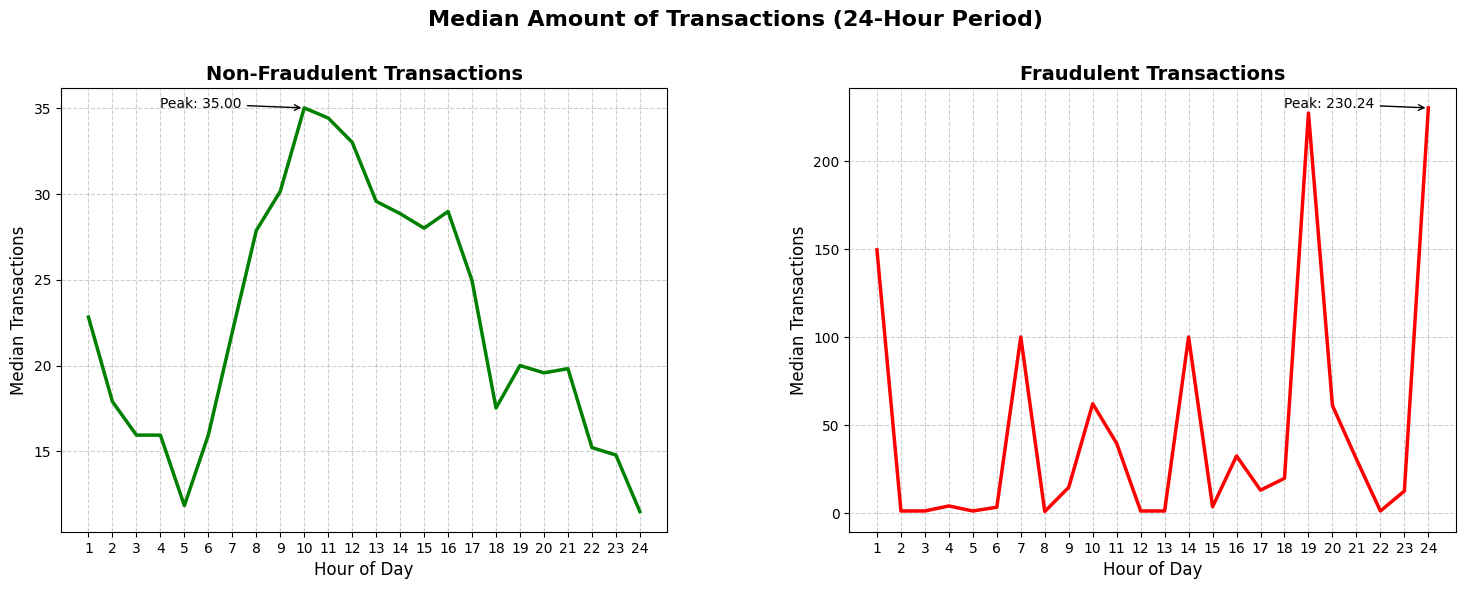

In [9]:
# Create a line chart
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 6), dpi=100, gridspec_kw={'wspace': 0.3})

# Plot for non-fraudulent transactions
sns.lineplot(
    ax=ax1, 
    x="Hour", 
    y="Median",  # 
    data=data_grouped_df_24h.loc[data_grouped_df_24h.Fraud_Flag == 0], 
    color="green", 
    linewidth=2.5, 
)
ax1.set_title("Non-Fraudulent Transactions", fontsize=14, fontweight="bold")
ax1.set_xlabel("Hour of Day", fontsize=12)
ax1.set_ylabel("Median Transactions", fontsize=12)  
ax1.set_xticks(range(1, 25))
ax1.grid(visible=True, linestyle="--", alpha=0.6)

# Peak for non-fraudulent transactions
peak_hour_nf = data_grouped_df_24h.loc[data_grouped_df_24h.Fraud_Flag == 0].sort_values(by="Median", ascending=False).iloc[0]
ax1.annotate(
    f"Peak: {peak_hour_nf['Median']:.2f}",
    xy=(peak_hour_nf['Hour'], peak_hour_nf['Median']),
    xytext=(peak_hour_nf['Hour'] - 6, peak_hour_nf['Median']),  
    arrowprops=dict(facecolor='black', arrowstyle="->"),
    fontsize=10
)

# Plot for fraudulent transactions
sns.lineplot(
    ax=ax2, 
    x="Hour", 
    y="Median",  
    data=data_grouped_df_24h.loc[data_grouped_df_24h.Fraud_Flag == 1], 
    color="red", 
    linewidth=2.5, 
)
ax2.set_title("Fraudulent Transactions", fontsize=14, fontweight="bold")
ax2.set_xlabel("Hour of Day", fontsize=12)
ax2.set_ylabel("Median Transactions", fontsize=12)  
ax2.set_xticks(range(1, 25))
ax2.grid(visible=True, linestyle="--", alpha=0.6)

# Peak for fraudulent transactions
peak_hour_f = data_grouped_df_24h.loc[data_grouped_df_24h.Fraud_Flag == 1].sort_values(by="Median", ascending=False).iloc[0]
ax2.annotate(
    f"Peak: {peak_hour_f['Median']:.2f}",
    xy=(peak_hour_f['Hour'], peak_hour_f['Median']),
    xytext=(peak_hour_f['Hour'] - 6, peak_hour_f['Median']),  
    arrowprops=dict(facecolor='black', arrowstyle="->"),
    fontsize=10
)

# Set the title
plt.suptitle("Median Amount of Transactions (24-Hour Period)", fontsize=16, fontweight="bold")

# Adjust the layout so that the title doesn't overlap with the plots
plt.subplots_adjust(top=0.85)  
#plt.tight_layout(rect=[0, 0, 1, 0.95]) - uncomment if needed for better spacing

# Display the plot
plt.show()

## Maximum Transaction by Hour

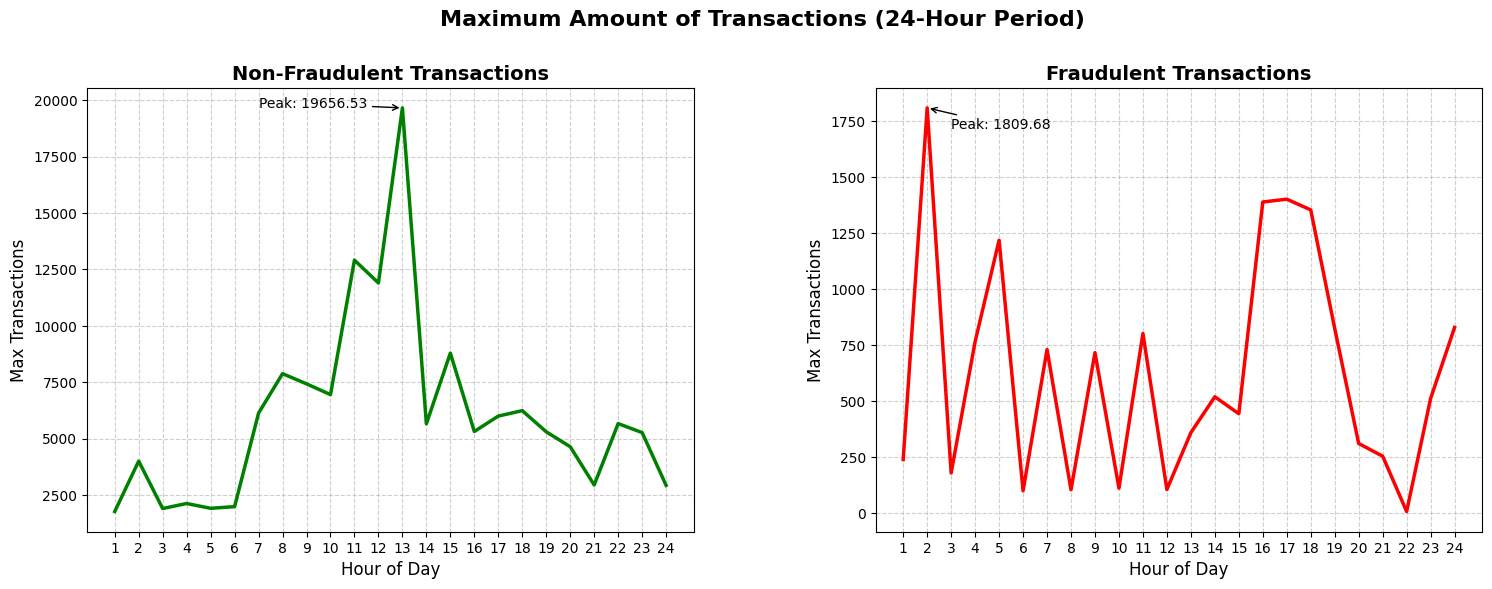

In [10]:
# Create a line chart
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 6), dpi=100, gridspec_kw={'wspace': 0.3})

# Plot for non-fraudulent transactions
sns.lineplot(
    ax=ax1, 
    x="Hour", 
    y="Max",  # Use Max instead of Median
    data=data_grouped_df_24h.loc[data_grouped_df_24h.Fraud_Flag == 0], 
    color="green", 
    linewidth=2.5, 
)
ax1.set_title("Non-Fraudulent Transactions", fontsize=14, fontweight="bold")
ax1.set_xlabel("Hour of Day", fontsize=12)
ax1.set_ylabel("Max Transactions", fontsize=12)  # Update label to reflect Max
ax1.set_xticks(range(1, 25))
ax1.grid(visible=True, linestyle="--", alpha=0.6)

# Peak for non-fraudulent transactions
peak_hour_nf = data_grouped_df_24h.loc[data_grouped_df_24h.Fraud_Flag == 0].sort_values(by="Max", ascending=False).iloc[0]
ax1.annotate(
    f"Peak: {peak_hour_nf['Max']:.2f}",
    xy=(peak_hour_nf['Hour'], peak_hour_nf['Max']),
    xytext=(peak_hour_nf['Hour'] - 6, peak_hour_nf['Max']),  
    arrowprops=dict(facecolor='black', arrowstyle="->"),
    fontsize=10
)

# Plot for fraudulent transactions
sns.lineplot(
    ax=ax2, 
    x="Hour", 
    y="Max",  # Use Max instead of Median
    data=data_grouped_df_24h.loc[data_grouped_df_24h.Fraud_Flag == 1], 
    color="red", 
    linewidth=2.5, 
)
ax2.set_title("Fraudulent Transactions", fontsize=14, fontweight="bold")
ax2.set_xlabel("Hour of Day", fontsize=12)
ax2.set_ylabel("Max Transactions", fontsize=12)  # Update label to reflect Max
ax2.set_xticks(range(1, 25))
ax2.grid(visible=True, linestyle="--", alpha=0.6)

# Peak for fraudulent transactions
peak_hour_f = data_grouped_df_24h.loc[data_grouped_df_24h.Fraud_Flag == 1].sort_values(by="Max", ascending=False).iloc[0]
ax2.annotate(
    f"Peak: {peak_hour_f['Max']:.2f}",
    xy=(peak_hour_f['Hour'], peak_hour_f['Max']),
    xytext=(peak_hour_f['Hour'] + 1, peak_hour_f['Max'] - ax2.get_ylim()[1] * 0.05),   
    arrowprops=dict(facecolor='black', arrowstyle="->"),
    fontsize=10
)

# Set the title
plt.suptitle("Maximum Amount of Transactions (24-Hour Period)", fontsize=16, fontweight="bold")

# Adjust the layout so that the title doesn't overlap with the plots
plt.subplots_adjust(top=0.85)  
#plt.tight_layout(rect=[0, 0, 1, 0.95]) - uncomment if needed for better spacing

# Display the plot
plt.show()

## Minimum Transaction by Hour

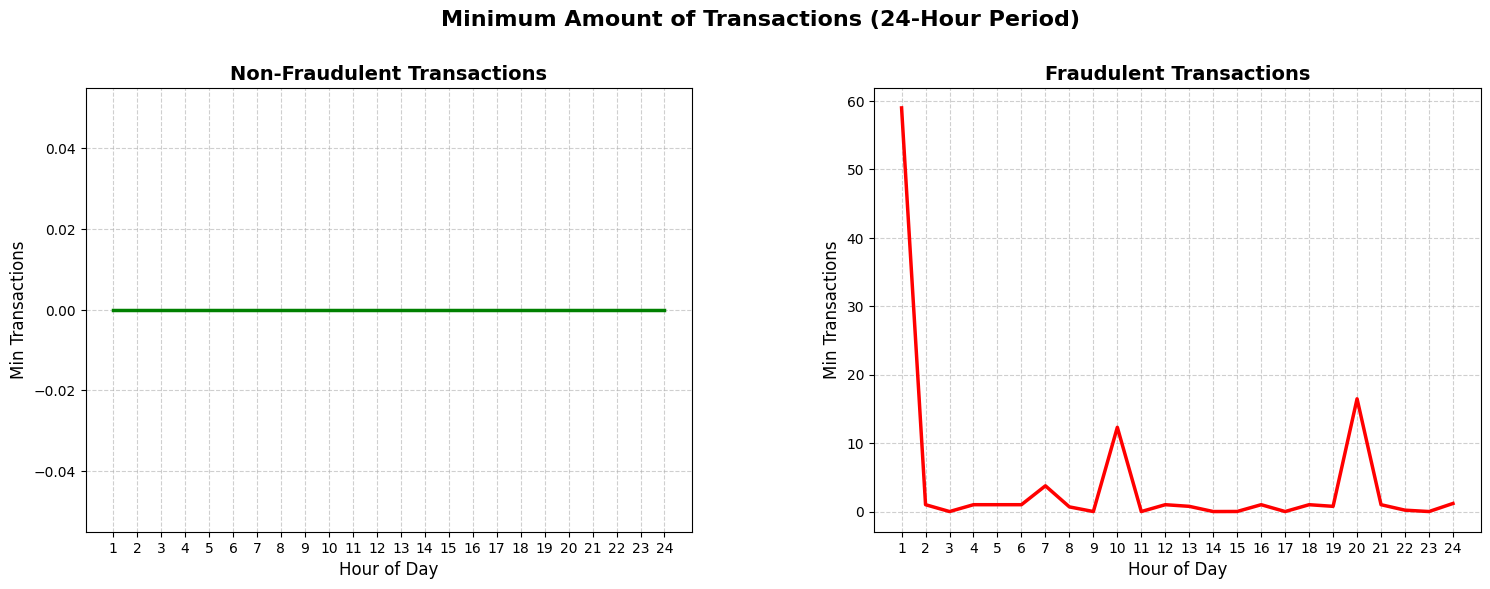

In [11]:
# Create a line chart
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 6), dpi=100, gridspec_kw={'wspace': 0.3})

# Plot for non-fraudulent transactions
sns.lineplot(
    ax=ax1, 
    x="Hour", 
    y="Min",  # Use Min instead of Max
    data=data_grouped_df_24h.loc[data_grouped_df_24h.Fraud_Flag == 0], 
    color="green", 
    linewidth=2.5, 
)
ax1.set_title("Non-Fraudulent Transactions", fontsize=14, fontweight="bold")
ax1.set_xlabel("Hour of Day", fontsize=12)
ax1.set_ylabel("Min Transactions", fontsize=12)  # Update label to reflect Min
ax1.set_xticks(range(1, 25))
ax1.grid(visible=True, linestyle="--", alpha=0.6)

# Plot for fraudulent transactions
sns.lineplot(
    ax=ax2, 
    x="Hour", 
    y="Min",  # Use Min instead of Max
    data=data_grouped_df_24h.loc[data_grouped_df_24h.Fraud_Flag == 1], 
    color="red", 
    linewidth=2.5, 
)
ax2.set_title("Fraudulent Transactions", fontsize=14, fontweight="bold")
ax2.set_xlabel("Hour of Day", fontsize=12)
ax2.set_ylabel("Min Transactions", fontsize=12)  # Update label to reflect Min
ax2.set_xticks(range(1, 25))
ax2.grid(visible=True, linestyle="--", alpha=0.6)

# Set the title
plt.suptitle("Minimum Amount of Transactions (24-Hour Period)", fontsize=16, fontweight="bold")

# Adjust the layout so that the title doesn't overlap with the plots
plt.subplots_adjust(top=0.85)  
#plt.tight_layout(rect=[0, 0, 1, 0.95]) - uncomment if needed for better spacing

# Display the plot
plt.show()

# Peaks removed from the Min plot, as they are not relevant for the Min value.

## Box Plot of Transactions by Fraud Status: With and Without Outliers

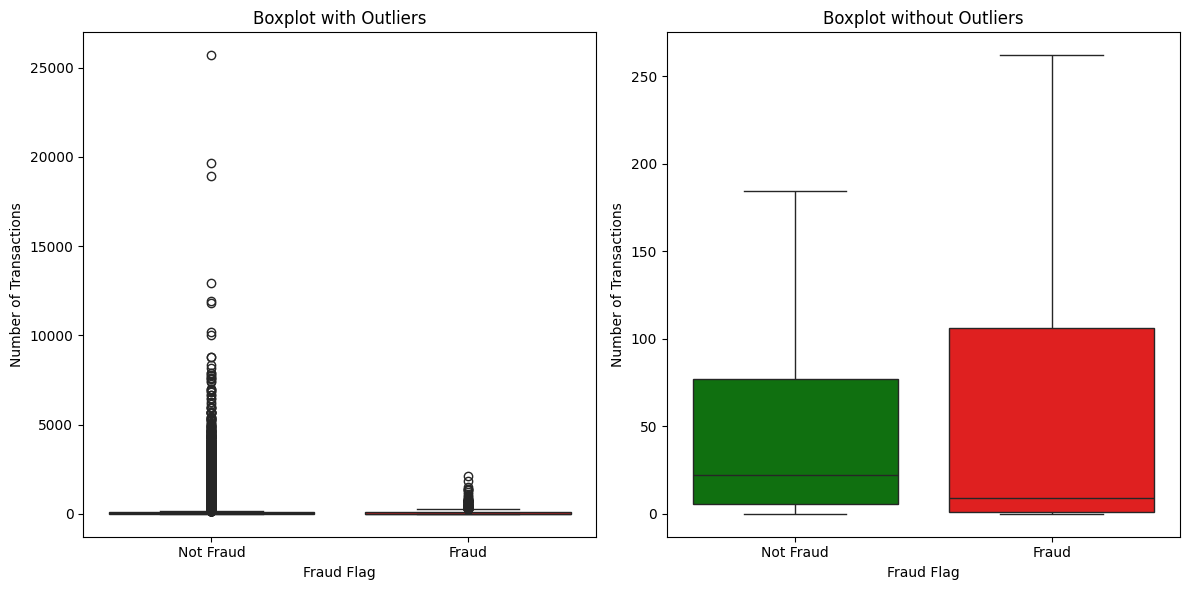

In [12]:
# Rename some columns and map Fraud Flag values
data_box_plot = data.rename(columns={'Fraud_Flag': 'Fraud Flag', 'Transaction_Amount': 'Number of Transactions'})
data_box_plot['Fraud Flag'] = data_box_plot['Fraud Flag'].map({0: 'Not Fraud', 1: 'Fraud'})

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

# Define a custom palette for Fraud Flag
custom_palette = {'Not Fraud': 'green', 'Fraud': 'red'}

# Boxplot with outliers
sns.boxplot(
    ax=ax1,
    x="Fraud Flag",
    y="Number of Transactions",
    hue="Fraud Flag",
    data=data_box_plot,
    palette=custom_palette,
    showfliers=True
)
ax1.set_title("Boxplot with Outliers")

# Boxplot without outliers
sns.boxplot(
    ax=ax2,
    x="Fraud Flag",
    y="Number of Transactions",
    hue="Fraud Flag",
    data=data_box_plot,
    palette=custom_palette,
    showfliers=False
)
ax2.set_title("Boxplot without Outliers")

plt.tight_layout()
plt.show()

## Descriptive Statistics for Transaction Amounts by Fraud Status

In [13]:
# Create new DataFrames for statistics
stats = data[['Transaction_Amount','Fraud_Flag']].copy()
Not_Fraud = stats.loc[stats['Fraud_Flag'] == 0]['Transaction_Amount']
Fraud = stats.loc[stats['Fraud_Flag'] == 1]['Transaction_Amount']
Not_Fraud.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Transaction_Amount, dtype: float64

In [14]:
Fraud.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Transaction_Amount, dtype: float64

## Scatter Plot of Fraudulent Transactions: Time vs Amount

In [15]:
# Create a scatter plot for fraudulent transactions
data_for_scatter_plot = data.loc[data['Fraud_Flag'] == 1]
data_for_scatter_plot['Transaction_Time'] = data_for_scatter_plot['Transaction_Time'] / 3600  # Convert to hours
data_for_scatter_plot['Transaction_Amount'] = data_for_scatter_plot['Transaction_Amount'].astype(float)  # Ensure it's float

trace = go.Scatter(
    x=data_for_scatter_plot['Transaction_Time'],
    y=data_for_scatter_plot['Transaction_Amount'],
    name="Transaction Amount",
    marker=dict(
        color='rgb(238,23,11)',
        line=dict(
            color='red',
            width=1
        ),
        opacity=0.5,
    ),
    text=data_for_scatter_plot['Transaction_Amount'],
    mode="markers"
)

scatter_plot_data= [trace]
layout = dict(
    title='Amount of Fraudulent Transactions',
    xaxis=dict(title='Time [h]', showticklabels=True),
    yaxis=dict(title='Amount'),
    hovermode='closest'
)

fig = dict(data=scatter_plot_data, layout=layout) 
iplot(fig, filename='fraud-amount')

## Save Data to CSV

In [16]:
data.to_csv(f"{working_directory}/Input_Data/creditcard_post_exploration.csv", index=False)